In [ ]:
!pip install wikipedia

In [ ]:
!pip install python-dotenv

In [ ]:
!pip install litellm

In [ ]:
!pip install rich

In [ ]:
import textwrap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wikipedia
from dotenv import load_dotenv
from litellm import embedding
from rich.align import Align
from rich.columns import Columns
from rich.console import Console
from rich.panel import Panel
from scipy.signal import find_peaks

load_dotenv()

False

In [ ]:
!pip install wikipedia-sections

In [ ]:
res=wikipedia.page("Linear Algebra", auto_suggest=False)
text1=res.content
section_1_1=res.section(res.sections[3])
section_1_2=res.section(res.sections[4])

res=wikipedia.page("Francis I of France", auto_suggest=False)
text2=res.content
section_2_1=res.section(res.sections[5])
section_2_2=res.section(res.sections[3])

res=wikipedia.page("Cricket", auto_suggest=False)
text3=res.content
section_3_1=res.section(res.sections[3])
section_3_2=res.section(res.sections[5])

res=wikipedia.page("United Nation", auto_suggest=False)
text4=res.content
section_4_1=res.section(res.sections[4])
section_4_2=res.section(res.sections[1])

sections=[section_1_1, section_2_1,section_3_1,section_4_1, section_1_2, section_2_2, section_3_2, section_4_2]


creating pipeline

In [ ]:
def sentence_splitter(df: pd.DataFrame) -> pd.DataFrame:

   print("Before splitting in sentences")
   display(df.head(10))
   df =  (
         df.set_index("section_id")
        .section.str.split("\. ", expand=True)
        .stack()
        .reset_index()
        .rename(columns={0: "sentence"})
        .drop(columns=["level_1"])
    )
   df["sentence"] = df["sentence"].str.strip()
   print("After splitting in sentences")
   display(df.head(10))
   print()
   return df

In [ ]:
def sentence_grouper(df: pd.DataFrame, group_size: int) -> pd.DataFrame:

    print("Before grouping in windows")
    display(df.iloc[5:15])
    groups = [df.iloc[i : i + group_size] for i in range(len(df) - group_size + 1)]
    df_grouped = pd.concat(
        [
            pd.DataFrame(
                {
                    "sentences": [group["sentence"].tolist()],
                    "section_ids": [group["section_id"].tolist()],
                    "section_split": [len(set(group["section_id"])) > 1],
                    "section_split_position": [
                        next(
                            (
                                i
                                for i in range(1, len(group))
                                if group["section_id"].iloc[i]
                                != group["section_id"].iloc[i - 1]
                            ),
                            -1,
                        )
                        if len(group) > 1
                        else -1
                    ],
                }
            )
            for group in groups
        ],
        ignore_index=True,
    )
    df_grouped.loc[~df_grouped["section_split"], "section_split_position"] = -1
    print("After grouping in windows")
    display(df_grouped.iloc[5:15])
    print()
    return df_grouped

In [ ]:
!pip install sentence_transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
def group_embedder(df: pd.DataFrame, batch_size: int) -> pd.DataFrame:
    """
    Embeds the sentences in the given DataFrame into two separate groups using a specified batch size.

    Args:
        df (pd.DataFrame): The DataFrame containing the sentences to be embedded.
        batch_size (int): The number of sentences to process in each batch.

    Returns:
        pd.DataFrame: The DataFrame with two additional columns, "embedding_1" and "embedding_2",
                      containing the embeddings of the sentences in the two groups.
    """
    print("Before computing embeddings")
    display(df.iloc[5:15])
    embeddings_1 = []
    embeddings_2 = []
    model = SentenceTransformer("all-MiniLM-L6-v2")

    for i in range(0, len(df), batch_size):
        batch = df["sentences"].iloc[i : i + batch_size].tolist()
        batch_1 = [".".join(sentences[: len(sentences) // 2]) for sentences in batch]
        batch_2 = [".".join(sentences[len(sentences) // 2 :]) for sentences in batch]

    batch_embeddings_1 = model.encode(batch_1, show_progress_bar=True)
    batch_embeddings_2 = model.encode(batch_2, show_progress_bar=True)
    embeddings_1.extend(batch_embeddings_1)
    embeddings_2.extend(batch_embeddings_2)

    df["embedding_1"] = embeddings_1
    df["embedding_2"] = embeddings_2
    print("After computing embeddings")
    display(df.iloc[5:15])
    return df

create the data frame

In [ ]:
WINDOW_SIZE = 6
EMBEDDING_BATCH_SIZE = 200

df = pd.DataFrame({
    "section": sections,
    "section_id": range(len(sections))
})

df = (
    df.pipe(sentence_splitter)
    .pipe(sentence_grouper, WINDOW_SIZE)
    .pipe(group_embedder, EMBEDDING_BATCH_SIZE)

)

Before splitting in sentences


,section,section_id
0,The study of those subsets of vector spaces th...,0
1,Although the Italian Wars (1494–1559) came to ...,1
2,The game underwent major development in the 18...,2
3,Though the UN's primary mandate was peacekeepi...,3
4,Matrices allow explicit manipulation of finite...,4
5,Francis was also renowned as a man of letters....,5
6,The inter-war years were dominated by Australi...,6
7,"In the century prior to the UN's creation, sev...",7


After splitting in sentences


,section_id,sentence
0,0,The study of those subsets of vector spaces th...
1,0,These subsets are called linear subspaces
2,0,"More precisely, a linear subspace of a vector ..."
3,0,(These conditions suffice for implying that W ...
4,0,The span of S is also the intersection of all ...
5,0,"In other words, it is the smallest (for the in..."
6,0,"Equivalently, a set S of vectors is linearly i..."
7,0,If a spanning set S is linearly dependent (tha...
8,0,One may continue to remove elements of S until...
9,0,Such a linearly independent set that spans a v...



Before grouping in windows


,section_id,sentence
5,0,"In other words, it is the smallest (for the in..."
6,0,"Equivalently, a set S of vectors is linearly i..."
7,0,If a spanning set S is linearly dependent (tha...
8,0,One may continue to remove elements of S until...
9,0,Such a linearly independent set that spans a v...
10,0,The importance of bases lies in the fact that ...
11,0,"More precisely, if S is a linearly independent..."
12,0,"Moreover, two vector spaces over the same fiel..."
13,0,"If U is a subspace of V, then dim U ≤ dim V"
14,0,"In the case where V is finite-dimensional, the..."


After grouping in windows


,sentences,section_ids,section_split,section_split_position
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1



Before computing embeddings


,sentences,section_ids,section_split,section_split_position
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

After computing embeddings


,sentences,section_ids,section_split,section_split_position,embedding_1,embedding_2
5,"[In other words, it is the smallest (for the i...","[0, 0, 0, 0, 0, 0]",False,-1,"[-0.028117375, -0.023928432, -0.051908664, 0.1...","[-0.035919175, 0.03133725, -0.040248044, 0.047..."
6,"[Equivalently, a set S of vectors is linearly ...","[0, 0, 0, 0, 0, 0]",False,-1,"[-0.052318573, -0.01305693, -0.04198246, 0.103...","[-0.007167246, -0.03913997, -0.050173704, 0.05..."
7,[If a spanning set S is linearly dependent (th...,"[0, 0, 0, 0, 0, 0]",False,-1,"[-0.07192597, 0.0015856514, -0.027098445, 0.11...","[-0.018884748, -0.0027462048, -0.0021710803, 0..."
8,[One may continue to remove elements of S unti...,"[0, 0, 0, 0, 0, 0]",False,-1,"[-0.035919175, 0.03133725, -0.040248044, 0.047...","[0.01189802, -0.0054795966, 0.010776623, 0.033..."
9,[Such a linearly independent set that spans a ...,"[0, 0, 0, 0, 0, 0]",False,-1,"[-0.0071672183, -0.03913997, -0.050173696, 0.0...","[0.054949787, 0.021086903, 0.06663491, 0.04282..."
10,[The importance of bases lies in the fact that...,"[0, 0, 0, 0, 0, 1]",True,5,"[-0.018884748, -0.0027462048, -0.0021710803, 0...","[-0.011173757, 0.031987138, 0.052366734, -0.00..."
11,"[More precisely, if S is a linearly independen...","[0, 0, 0, 0, 1, 1]",True,4,"[0.01189802, -0.0054795966, 0.010776623, 0.033...","[-0.03290827, 0.00021138054, 0.034723494, 0.00..."
12,"[Moreover, two vector spaces over the same fie...","[0, 0, 0, 1, 1, 1]",True,3,"[0.054949787, 0.021086903, 0.06663491, 0.04282...","[-0.05439528, 0.008917229, 0.048726123, -0.008..."
13,"[If U is a subspace of V, then dim U ≤ dim V, ...","[0, 0, 1, 1, 1, 1]",True,2,"[-0.011173757, 0.031987138, 0.052366734, -0.00...","[-0.057106763, 0.011664212, 0.0809705, 0.00018..."
14,"[In the case where V is finite-dimensional, th...","[0, 1, 1, 1, 1, 1]",True,1,"[-0.03290827, 0.00021138054, 0.034723494, 0.00...","[-0.08363399, 0.047172107, 0.07388265, -0.0337..."


In [ ]:
df_metrics = df.copy()

df_metrics["similarity"] = df.apply(
    lambda x: np.dot(x["embedding_1"], x["embedding_2"]), axis=1
)
df_metrics["divergence"] = 1 - df_metrics["similarity"]

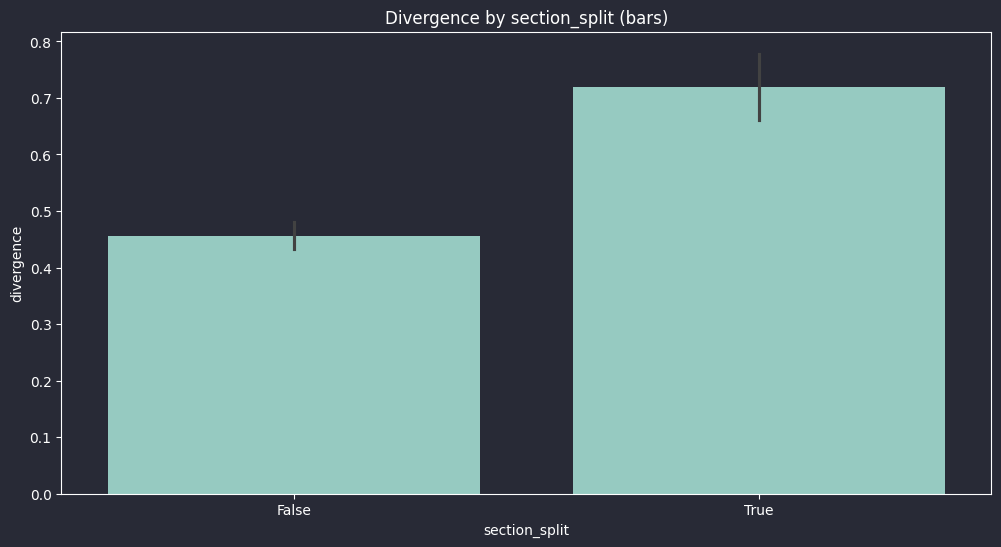

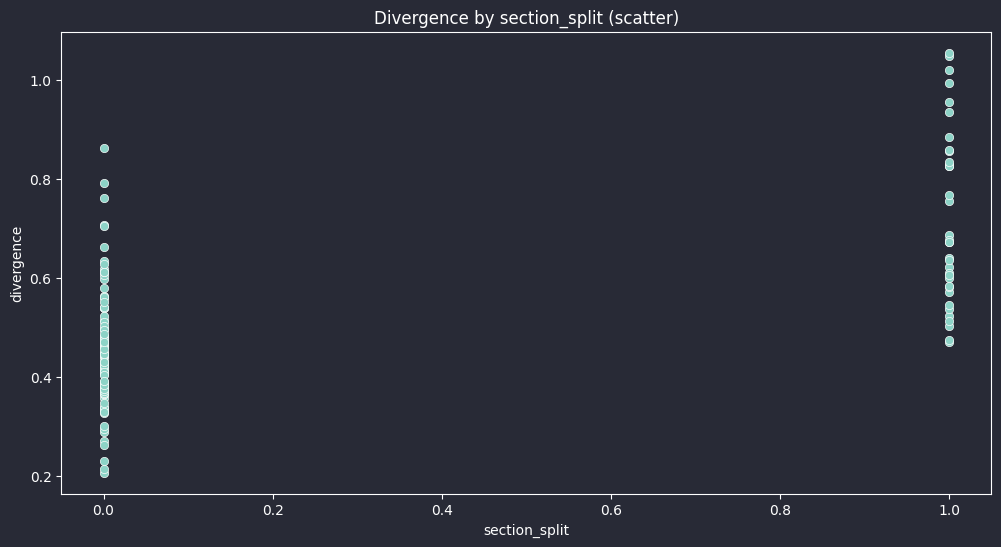

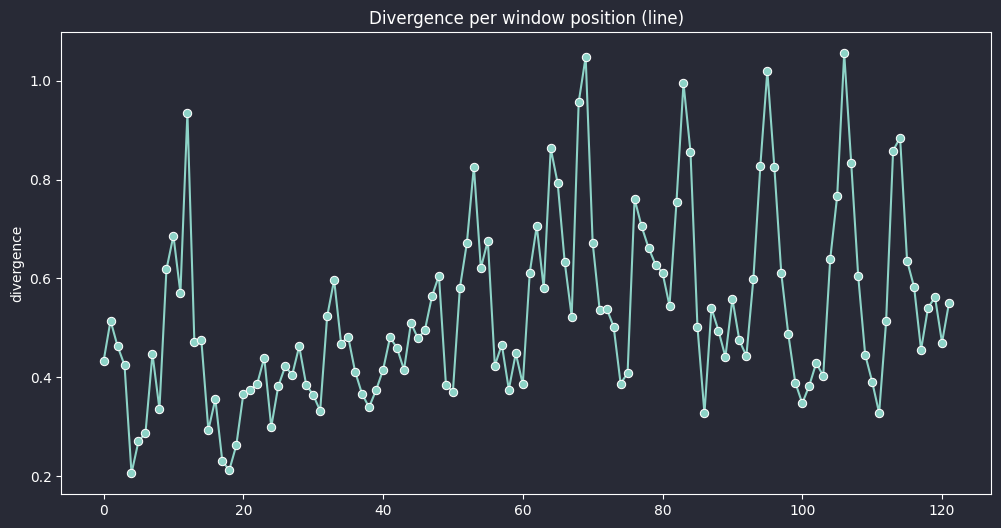

In [ ]:
plt.style.use("dark_background")
plt.rcParams["figure.facecolor"] = "#282a36"
plt.rcParams["axes.facecolor"] = "#282a36"

plt.figure(figsize=(12, 6))
sns.barplot(x="section_split", y="divergence", data=df_metrics)
plt.title("Divergence by section_split (bars)")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(x="section_split", y="divergence", data=df_metrics)
plt.title("Divergence by section_split (scatter)")
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=np.arange(df_metrics["divergence"].size),
    y=df_metrics["divergence"],
    data=df_metrics,
    marker="o",
)
plt.title("Divergence per window position (line)")
plt.show()